# Problem 2: Implementing a Multi-layer Perceptron

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
#!pip install seaborn
# Install seaborn (needed to plot confusion matrix) by uncommenting the above line

In [16]:
def sigmoid_forward(a):
    # calculates the sigmoid activation function
    # a: pre-activation values
    # returns: activated values
    
    return 1 / (1 + np.exp(-a));

def sigmoid_backward(grad_accum, a):
    # grad_accum: the gradient of the loss function w.r.t to z
    # a: the pre-activation values
    # returns: the gradient of the loss w.r.t to the preactivation values, a
    
    return (grad_accum * (np.exp(-a) / ((1 + np.exp(-a)) ** 2)))
    
def linear_forward(x, weight, bias):
    # Computes the forward pass of the linear layer
    # x: input of layer
    # weight, bias: weights and bias of neural network layer
    # returns: output of linear layer
    
    x = np.column_stack((np.ones(np.shape(x)[0]), x))
    weight = np.column_stack((bias, weight))
    return x @ weight.T

def linear_backward(grad_accum, x, weight, bias):
    #  Derivative of the linear layer w.r.t 
    # grad_accum: gradient of loss w.r.t function after linear layer
    # returns dl_dw: gradient of loss w.r.t to weights 
    # returns dl_dx: gradient of loss w.r.t to input, x  
    # return dl_dw, dl_dx
    
    x = np.column_stack((np.ones(np.shape(x)[0]), x))
    return grad_accum.T @ x, grad_accum @ weight
    
def softmax_xeloss_forward(b, labels):
    # Input parameters: 
    ## b: pre-activation 
    # calculates the softmax of the vector b
    # calculates the cross entropy loss between the softmax of b and the labels 
    # returns: l
    
    den = np.sum(np.exp(b), axis = 1)
    pred = np.exp(b) / np.tile(den[:, np.newaxis], (1, 10))
    l = -np.sum(labels * (np.log(pred)), axis = 1)
    return l
    
def softmax_xeloss_backward(yhat, labels):
    # Input parameters:
    # yhat: predictions of the neural network
    # labels: target of the network
    # returns: dl_db gradient of loss w.r.t to b
    
    dl_db = (-labels * (1 - yhat))
    return dl_db
    
def data_load():
    # load in the data provided in "data/"
    # Unzip fashion_mnist.zip
    
    train = np.loadtxt("fashion_mnist/train.csv", delimiter = ",");
    test = np.loadtxt("fashion_mnist/test.csv", delimiter = ",");
    
    x_train = train[:, :-1]
    y_train = train[:, -1]
    
    x_test = test[:, :-1]
    y_test = test[:, -1]
    
    return x_train, y_train, x_test, y_test

def load_params():
    alpha_weights = np.loadtxt('params/alpha1.txt', delimiter=',')
    beta_weights = np.loadtxt('params/alpha2.txt', delimiter=',')
    alpha_bias= np.loadtxt('params/beta1.txt', delimiter=',')
    beta_bias = np.loadtxt('params/beta2.txt', delimiter=',')
    return alpha_weights, beta_weights, alpha_bias, beta_bias

def one_hot_encode(y):
    # convert categorical target features to one hot encoded data
    
    encode_data = np.zeros((np.shape(y)[0], 10))
    y = np.array(y, dtype = "int")
    for column in range(np.shape(y)[0]):
        encode_data[column, y[column]] = 1
    return encode_data

def train(batchsize=1 , eta = 0.01, num_epochs=100, h = 256, init='default'):
    x_train, y_train, x_test, y_test = data_load()  
    
    y_train = one_hot_encode(y_train) 
    y_test = one_hot_encode(y_test) 

    if init == 'default':
       alpha_weights, beta_weights, alpha_bias, beta_bias = load_params()
    elif init=='zeros':
        # initialize weights and biases to 0
        alpha_weights, beta_weights, alpha_bias, beta_bias = load_params() * 0
    elif init=='ones':
        # initialize weights and biases to 1
        alpha_weights, beta_weights, alpha_bias, beta_bias = load_params() * 0 + 1
    elif init=='random':
        # initialize weights and biases to random values between -1 and 1
        pass
        
    train_loss_list = []
    test_loss_list = []
    acc_list = []    

    for epoch in (range(num_epochs)):
        print("Epoch :", epoch)
        
        for batch in range(int(len(x_train) / batchsize) + (len(x_train) % batchsize > 0)):
            batch_x = x_train[batch * batchsize:(batch + 1) * batchsize, :]
            batch_y = y_train[batch * batchsize:(batch + 1) * batchsize, :]
            
            ######## FORWARD 
            # Linear -> Sigmoid -> Linear -> Softmax
            A = linear_forward(batch_x, alpha_weights, alpha_bias)
            Z = sigmoid_forward(A)
            B = linear_forward(Z, beta_weights, beta_bias)
            L = softmax_xeloss_forward(B, batch_y)
            ######## BACKWARD 
            den = np.sum(np.exp(B), axis = 1)
            yhat = np.exp(B) / den
            dl_db = softmax_xeloss_backward(yhat, batch_y)
            dl_dbeta, dl_dz = linear_backward(dl_db, Z, beta_weights, beta_bias)
            dl_da = sigmoid_backward(dl_dz, A)
            dl_dalpha, dl_dx = linear_backward(dl_da, batch_x, alpha_weights, alpha_bias)
            ######## UPDATE
            alpha_weights = alpha_weights - dl_dalpha[:, 1:] * eta
            beta_weights = beta_weights - dl_dbeta[:, 1:] * eta
            alpha_bias = alpha_bias - dl_dalpha[:, 0] * eta
            beta_bias = beta_bias - dl_dbeta[:, 0] * eta

        # store average training loss for the epoch
        # calculate test predictions and loss
        num_test = np.shape(x_train)[0]
        A = linear_forward(x_train, alpha_weights, alpha_bias)
        Z = sigmoid_forward(A)
        B = linear_forward(Z, beta_weights, beta_bias)
        L = softmax_xeloss_forward(B, y_train)
        
        train_loss_list.append(np.sum(L)/num_test)
        y_hat_train = np.exp(B)/np.sum(np.exp(B), axis = 0)
        train_pred = np.argmax(y_hat_train, axis = 1)[:]
        vector_corr = train_pred == np.argmax(y_train, axis = 1)[:]
        
        #Test
        num_test = np.shape(x_test)[0]
        A = linear_forward(x_test, alpha_weights, alpha_bias)
        Z = sigmoid_forward(A)
        B = linear_forward(Z, beta_weights, beta_bias)
        L = softmax_xeloss_forward(B, y_test)
        
        test_loss_list.append(np.sum(L)/num_test)
        den = np.sum(np.exp(B), axis = 1)
        y_hat_test = np.exp(B)/np.sum(np.exp(B), axis = 0)
        test_pred = np.exp(B)/np.sum(np.exp(B), axis = 0)
        vector_correct = np.argmax(test_pred, axis = 1)[:] == np.argmax(y_test, axis = 1)[:]
        
        # calculate test accuracy
        acc_list.append(np.sum(vector_correct) / num_test)
        
    # return train_loss_list, test_loss_list, as well as test and train predictions
    return train_loss_list, test_loss_list, acc_list, y_hat_train, y_hat_test
    


In [17]:
train_loss_list, test_loss_list, acc_list, yhatTrain, yhatTest = train(num_epochs = 20, eta = 0.0002)

Epoch : 0
Epoch : 1
Epoch : 2
Epoch : 3
Epoch : 4
Epoch : 5
Epoch : 6
Epoch : 7
Epoch : 8
Epoch : 9
Epoch : 10
Epoch : 11
Epoch : 12
Epoch : 13
Epoch : 14
Epoch : 15
Epoch : 16
Epoch : 17
Epoch : 18
Epoch : 19


# Plot Loss 

In [18]:
# Plot training loss, testing loss as a function of epochs

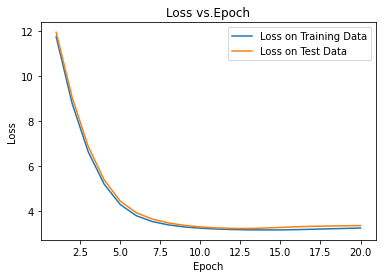

In [19]:
epochs = np.arange(1, 21);
plt.figure()
plt.plot(epochs, train_loss_list, label = "Loss on Training Data")
plt.plot(epochs, test_loss_list, label = "Loss on Test Data")
plt.title("Loss vs.Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Confusion Matrix

(1000,)


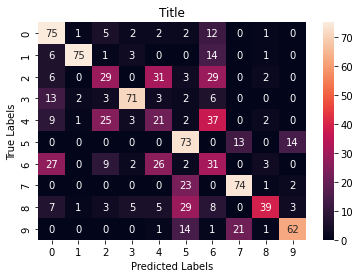

In [20]:
def plot_confusion(yhat, y, title = '[Training or Test] Set'):

    pred_train = np.argmax(yhat, axis=1)
    true_train = np.argmax(y, axis=1)
    print(true_train.shape)
    conf_train = np.zeros((10,10))
    for i in range(len(y)):
        conf_train[ true_train[i], pred_train[i] ] += int(1)
        
    sns.heatmap(conf_train, annot=True, fmt='.3g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Title')
    plt.show()
# plot_confusion(yhat_train, y_train, title = "Training Set")
# plot_confusion(yhat_test, y_test, title = "Test Set")
#yhat: predictions
#y: one-hot-encoded labels

X_train, y_train, X_test, y_test = data_load()
y_test = one_hot_encode(y_test)
plot_confusion(yhatTest, y_test, title = "Test Data")

# Correct and Incorrect Classification Samples

In [8]:
def plot_image(vector, out_f_name, label=None):
    """
    Takes a vector as input of size (784) and saves as an image
    """
    image = np.asarray(vector).reshape(28, 28)
    plt.imshow(image, cmap='gray')
    if label:
        plt.title(label)
    plt.axis('off')
    plt.savefig(f'{out_f_name}.png', bbox_inches='tight')
    plt.show()


In [9]:
# Use plot_image function to display samples that are correctly and incorrectly predicted

# Effect Of Learning Rate

In [10]:
# Plot test loss as a function of epochs

# Effect of Initialization

In [11]:
# Plot test loss as a function of epochs